In [1]:
!pip install transformers torch scikit-learn matplotlib seaborn pandas joblib
!pip install -U accelerate
!pip install -U transformers
!pip install tf-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 39.7 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.9/780.9 kB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [transformers] [transformers]ub]

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


Balanced dataset size: 294
Device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,3.814568
2,4.015600,3.527035
3,3.478700,3.501490
4,3.288100,3.456588
5,3.186100,3.402051
6,3.083700,3.497968
7,3.083700,3.522213
8,2.928600,3.592895
9,2.765800,3.561313
10,2.564100,3.544947


Saved: plots/bert_zork_modelV05_train_val_loss_curve.png


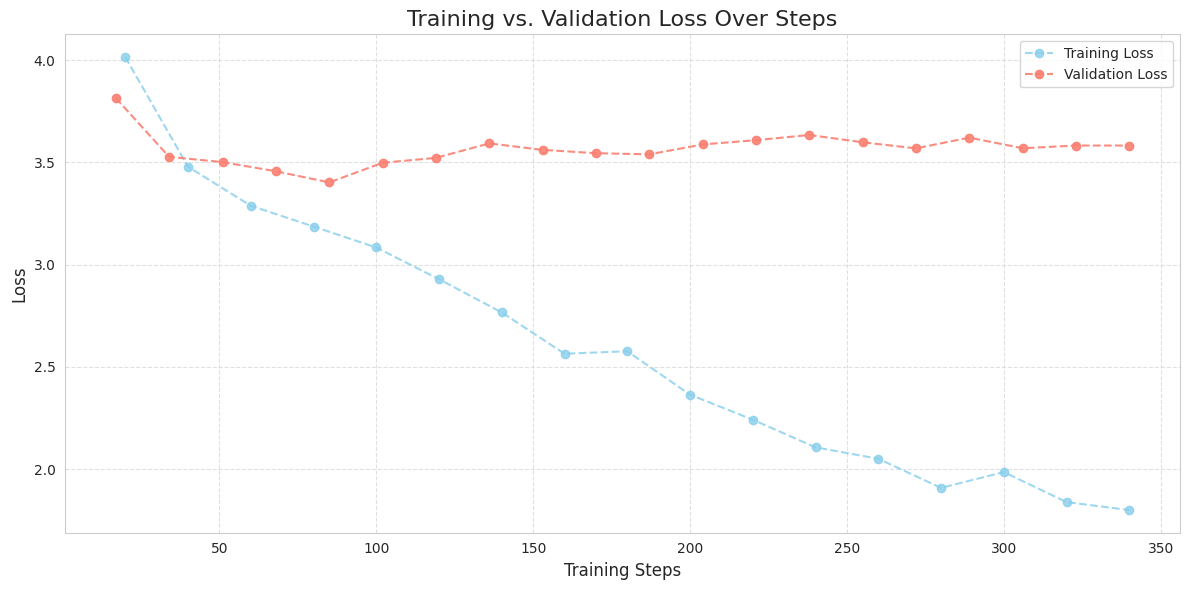

Training complete and model saved!
Saved final classification report to: plots/bert_zork_modelV05_classification_report.txt


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metric

Saved: plots/bert_zork_modelV05_confusion_matrix.png
Training complete and model saved!


<Figure size 2600x2600 with 0 Axes>

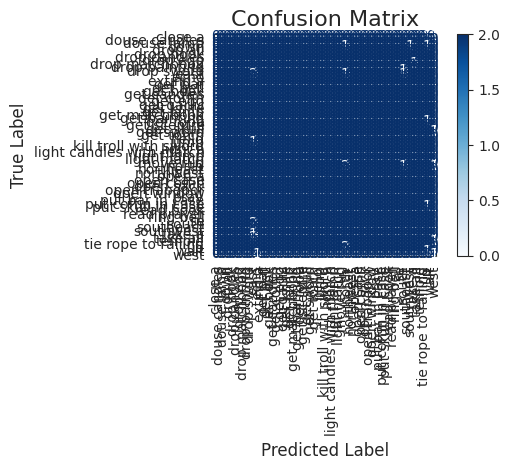

In [14]:
import json
import os
import joblib
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns # Added for better plotting aesthetics
from sklearn.metrics import classification_report, accuracy_score

# Define a normalization dictionary for common actions (matches player's map)
ACTION_NORMALIZATION_MAP = {
    'N': 'north', 'S': 'south', 'E': 'east', 'W': 'west', 'U': 'up', 'D': 'down'
}
le = LabelEncoder
class LossTrackerCallback(TrainerCallback):
    """Callback to track training and evaluation losses."""
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.eval_steps = []
        self.global_steps = [] # To store global steps for training loss

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and 'loss' in logs:
            self.train_losses.append(logs['loss'])
            self.global_steps.append(state.global_step) # Store global step for training loss

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics and 'eval_loss' in metrics:
            self.eval_losses.append(metrics['eval_loss'])
            self.eval_steps.append(state.global_step)

class JerichoDataset(Dataset):
    """Custom Dataset for Jericho game data."""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

def load_data_and_extract_pairs(filepath: str) -> tuple[list, list]:
    """Loads JSON data and extracts enriched state-action pairs."""
    with open(filepath, 'r') as f:
        data = json.load(f)
    inputs, targets = [], []
    for sample in data:
        state = sample['state']
        input_text = (
            f"Observation: {state['obs']}. Location: {state['loc_desc']}. "
            f"Inventory: {state['inv_desc']}. " 
            f"Surroundings: {' '.join(state['surrounding_objs'].keys())}. "
            f"Score: {state['score']}."
        )
        inputs.append(input_text)
        targets.append(sample['action'])
    return inputs, targets

def normalize_and_balance_data(inputs: list, targets: list) -> tuple[list, list]:
    """Normalizes actions and balances the dataset by downsampling."""
    normalized_targets = [ACTION_NORMALIZATION_MAP.get(a.strip(), a.strip().lower()) for a in targets]

    balanced_inputs, balanced_targets = [], []
    class_counts = Counter()
    for inp, tgt in zip(inputs, normalized_targets):
        max_count = 30 if tgt in ['north','south','east','west','up','down'] else 200
        if class_counts[tgt] < max_count:
            balanced_inputs.append(inp)
            balanced_targets.append(tgt)
            class_counts[tgt] += 1
    print(f"Balanced dataset size: {len(balanced_targets)}")
    return balanced_inputs, balanced_targets

def prepare_datasets(inputs: list, targets: list, model_path: str):
    """
    Prepares datasets for training: splits, encodes labels, tokenizes.
    Returns train_dataset, val_dataset, tokenizer, label_encoder, and y_val_encoded.
    """
    X_train, X_val, y_train, y_val = train_test_split(inputs, targets, test_size=0.1, random_state=42)

    le = LabelEncoder()
    le.fit(y_train + y_val)
    joblib.dump(le, os.path.join(model_path, 'label_encoder.joblib')) # Save label encoder

    y_train_enc, y_val_enc = le.transform(y_train), le.transform(y_val)

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_encodings = tokenizer(X_train, truncation=True, padding=True)
    val_encodings = tokenizer(X_val, truncation=True, padding=True)

    # Return y_val_enc explicitly so it can be used for the final report
    return JerichoDataset(train_encodings, y_train_enc), JerichoDataset(val_encodings, y_val_enc), tokenizer, le, y_val_enc


def setup_trainer(model_path: str, num_labels: int, train_dataset: Dataset, val_dataset: Dataset):
    """Sets up and returns the Hugging Face Trainer."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
    model.to(device)

    training_args = TrainingArguments(
        output_dir=os.path.join('/home/jovyan/shared/Jericho/models/', os.path.basename(model_path)),
        num_train_epochs=20,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=10,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=20,
        eval_strategy='epoch',
        #save_strategy='epoch', # Save checkpoints at each epoch
        #load_best_model_at_end=True, # Load the best model at the end of training
        #metric_for_best_model="eval_loss", # Metric to use for best model selection
        #greater_is_better=False, # Lower eval_loss is better
    )
    loss_tracker = LossTrackerCallback()
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        callbacks=[loss_tracker]
    )
    return trainer, loss_tracker
def plot_confusion_matrix(y_true, y_pred, class_names, save_path: str):
    """
    Plots and saves a confusion matrix.
    Args:
        y_true (array-like): True labels (decoded strings).
        y_pred (array-like): Predicted labels (decoded strings).
        class_names (array-like): All possible class names (e.g., le.classes_).
        save_path (str): Path to save the plot.
    """
    # Calculate confusion matrix.
    # Pass `labels=class_names` to ensure all classes are included and ordered correctly.
    cm = confusion_matrix(y_true, y_pred, labels=class_names) # <--- IMPORTANT: Added labels=class_names
    
    # Adjust figure size for many classes to prevent cramped labels
    fig_size = max(10, len(class_names) * 0.4) # Dynamic sizing, adjust multiplier as needed
    plt.figure(figsize=(fig_size, fig_size))
    sns.set_style("white") # Use a clean style for the matrix

    # Create ConfusionMatrixDisplay directly from the confusion matrix and display_labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    # Plot the confusion matrix
    # Use 'd' for integer format of counts, rotate x-ticks for readability
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='d') 

    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping

    plt.savefig(save_path, dpi=300)
    print(f"Saved: {save_path}")
    # plt.show() # Often commented out when running in non-interactive environments

def plot_loss_curve(loss_tracker: LossTrackerCallback, save_path: str):
    """
    Plots training and validation loss using seaborn for better aesthetics.
    The plot shows both training loss and validation loss against the training steps,
    allowing for a direct comparison of model performance on seen vs. unseen data.
    """
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid") # Use a nice seaborn style for better aesthetics

    # Plot Training Loss
    # `global_steps` ensures correct x-axis alignment even if logging_steps is large
    plt.plot(loss_tracker.global_steps, loss_tracker.train_losses,
             label='Training Loss', color='skyblue', marker='o', linestyle='--', markersize=6,linewidth=1.5, alpha=0.8)

    # Plot Validation Loss
    # `eval_steps` aligns validation loss with the global steps at which evaluations occurred
    plt.plot(loss_tracker.eval_steps, loss_tracker.eval_losses,
             label='Validation Loss', color='salmon', marker='o', linestyle='--', markersize=6, alpha=0.9)

    plt.title('Training vs. Validation Loss Over Steps', fontsize=16)
    plt.xlabel('Training Steps', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping

    plt.savefig(save_path, dpi=300) # Save with higher DPI for better quality
    print(f"Saved: {save_path}")
    plt.show()

if __name__ == "__main__":
    DATA_PATH = 'data/data_zork1.json'
    MODEL_NAME = 'bert_zork_modelV05' # New model name for improved prompts
    MODEL_PATH = os.path.join('/home/jovyan/shared/Jericho/models/', MODEL_NAME)
    PLOT_DIR = 'plots'
    os.makedirs(MODEL_PATH, exist_ok=True)
    os.makedirs(PLOT_DIR, exist_ok=True)

    # 1. Load data and extract pairs
    inputs, targets = load_data_and_extract_pairs(DATA_PATH)

    # 2. Normalize and balance data
    balanced_inputs, balanced_targets = normalize_and_balance_data(inputs, targets)

    # 3. Prepare datasets
    train_dataset, val_dataset, tokenizer, le, y_val_enc = prepare_datasets(
        balanced_inputs, balanced_targets, MODEL_PATH
    )
    # 4. Setup Trainer
    trainer, loss_tracker = setup_trainer(MODEL_PATH, len(label_classes), train_dataset, val_dataset)

    # 5. Train
    trainer.train()

    # 6. Save model & tokenizer
    trainer.save_model(MODEL_PATH)
    tokenizer.save_pretrained(MODEL_PATH)

    # 7. Plot training loss
    plot_loss_curve(loss_tracker, os.path.join(PLOT_DIR, f'{MODEL_NAME}_train_val_loss_curve.png'))


    print("Training complete and model saved!")
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    

    report_output_path = os.path.join(PLOT_DIR, f'{MODEL_NAME}_classification_report.txt')

    with open(report_output_path, 'w') as f:
        f.write("Classification Report\n")
        # <--- IMPORTANT: Added labels=le.classes_ here too
        f.write(classification_report(y_true_labels, y_pred_labels, labels=le.classes_, target_names=le.classes_))
        f.write("\n=====================\n")
        f.write(f"Accuracy: {accuracy_score(y_true_labels, y_pred_labels)}\n")
        f.write("=====================\n")

    print(f"Saved final classification report to: {report_output_path}")

    # --- Plot Confusion Matrix ---
    cm_plot_path = os.path.join(PLOT_DIR, f'{MODEL_NAME}_confusion_matrix.png')
    plot_confusion_matrix(y_true_labels, y_pred_labels, le.classes_, cm_plot_path)

    print("Training complete and model saved!")

In [8]:
# --- YOUR SIMPLIFIED CLASSIFICATION REPORT SECTION ---
print("\nGenerating final classification report...")
# Predict on the validation set
predictions_output = trainer.predict(val_dataset) # Changed variable name to avoid conflict
                                                      # predictions_output contains predictions, label_ids, metrics

# Get the predicted class indices
predicted_labels_encoded = predictions_output.predictions.argmax(axis=1)

    # Decode labels
y_pred_labels = le.inverse_transform(predicted_labels_encoded)
y_true_labels = le.inverse_transform(y_val_enc) # Use the stored y_val_enc

    # Define output path for the report
output_path = os.path.join(REPORT_DIR, f'{MODEL_NAME}_classification_report.txt') # Save in new reports dir

with open(output_path, 'w') as f:
    f.write("Classification Report\n")
    # Ensure target_names are passed for a readable report
    f.write(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))
    f.write("\n=====================\n") # Added newline for better formatting
    f.write(f"Accuracy: {accuracy_score(y_true_labels, y_pred_labels)}\n") # Corrected f-string for printing number
    f.write("=====================\n")

print(f"Saved final classification report to: {output_path}")


Generating final classification report...


TypeError: inverse_transform() missing 1 required positional argument: 'y'